In [20]:
import dlc_practical_prologue as prologue
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np #Only used for visualisation of digits

In [87]:
# Main network structure, plus training and compute errors functions

class DigitNet(nn.Module):
    
    def __init__(self):
        super(DigitNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, 5),
            nn.BatchNorm2d(4),
            #nn.Dropout2d(),
            nn.PReLU(),
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            #nn.Dropout2d(),
            nn.PReLU(),
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(),
            nn.PReLU()
            )
        self.fc = nn.Sequential(
            nn.Linear(16 * 6 * 6, 256),
            nn.BatchNorm1d(256),
            #nn.Dropout(),
            nn.PReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            #nn.Dropout(),
            nn.PReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )

    def forward(self, x):
        features = self.features(x)
        features = features.view(-1, 16 * 6 * 6)
        digit = self.fc(features)
        return digit
    

class PairSetsModel(nn.Module):

    def __init__(self, weight_sharing = True, use_auxiliary_loss = True):
        super(PairSetsModel, self).__init__()        
        self.weight_sharing = weight_sharing
        self.use_auxiliary_loss = use_auxiliary_loss        
        self.net1 = DigitNet()
        self.net2 = self.net1 if weight_sharing else DigitNet()        
        self.fc = nn.Linear(100, 1)

    def forward(self, image1, image2):
        digit1 = self.net1(image1)
        digit2 = self.net2(image2)
        digits = torch.bmm(digit1[:,:,None], digit2[:,None,:])
        prediction = self.fc(digits.view(-1, 100)).view(-1)       
        return prediction, digit1, digit2
    

def train_model(model, images1, images1_target, images2, images2_target,target, mini_batch_size, nb_epochs = 25):
    criterion = torch.nn.MSELoss()
    criterion_aux = torch.nn.MSELoss()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    for epoch in tqdm(range(nb_epochs)):    
        # Train
        epoch_loss = 0
        epoch_accuracy = 0
        for b in range(0, images1.size(0), mini_batch_size):
            images1_here = images1.narrow(0,b,mini_batch_size)
            images2_here = images2.narrow(0,b,mini_batch_size)
            prediction, digit1, digit2 = model(images1_here, images2_here)
            loss = criterion(prediction, target.narrow(0, b, mini_batch_size))
            epoch_loss += loss
            model.zero_grad()
            if model.use_auxiliary_loss: 
                    aux_loss = criterion_aux(digit1, images1_target.narrow(0,b,mini_batch_size)) 
                    aux_loss += criterion_aux(digit2, images2_target.narrow(0,b,mini_batch_size))
                    loss += aux_loss
            loss.backward()
            optimizer.step()
        print('epochs = ', epoch, ', loss = ', epoch_loss)

def compute_nb_errors(model, images1, images2, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, images1.size(0), mini_batch_size):
        images1_here = images1.narrow(0,b,mini_batch_size)
        images2_here = images2.narrow(0,b,mini_batch_size)
        prediction, digit1, digit2 = model(images1_here, images2_here)
        predicted_target = torch.empty(prediction.size())
        for k in range(mini_batch_size):
            predicted_target[k] = 0.0 if prediction[k]< 0.5 else 1.0
            if target[b + k] != predicted_target[k]:
                nb_errors = nb_errors + 1
    return nb_errors


In [88]:
# Data acquisition
N = 1000
get1 = prologue.generate_pair_sets(N)
# get1 will be a tuple of size 6: 
#      position 0 has a Nx2x14x14 torch containing train images
#      position 1 has a N torch containing train target [0 or 1]
#      position 2 has a Nx2 torch containing train classes [0,...,9]x[0,...,9]
#      position 3 has a Nx2x14x14 torch containing test images
#      position 4 has a N torch containing test target [0 or 1]
#      position 5 has a Nx2 torch containing test classes [0,...,9]x[0,...,9]

# Extract data from get1
train_images1 = get1[0][:,0,:, :].to(torch.float32)
train_images2 = get1[0][:,1,:, :].to(torch.float32)
train_classes_images1 = get1[2][:,0].to(torch.float32)
train_classes_images2 = get1[2][:,1].to(torch.float32)
train_target = get1[1].to(torch.float32)

test_images1 = get1[3][:,0,:, :].to(torch.float32)
test_images2 = get1[3][:,1,:, :].to(torch.float32)
test_classes_images1 = get1[5][:,0].to(torch.float32)
test_classes_images2 = get1[5][:,1].to(torch.float32)
test_target = get1[4].to(torch.float32)

train_classes_long_images1 = torch.zeros((train_classes_images1.size()[0], 10))
train_classes_long_images2 = torch.zeros((train_classes_images2.size()[0], 10))

test_classes_long_images1 = torch.zeros((test_classes_images1.size()[0], 10))
test_classes_long_images2 = torch.zeros((test_classes_images2.size()[0], 10))


for k in range(N):
    train_classes_long_images1[k, train_classes_images1[k].to(torch.int) ] = 1.0
    train_classes_long_images2[k, train_classes_images2[k].to(torch.int) ] = 1.0
    
    test_classes_long_images1[k, test_classes_images1[k].to(torch.int) ] = 1.0
    test_classes_long_images2[k, test_classes_images2[k].to(torch.int) ] = 1.0

# My version of pytorch makes me do this for the network to read inputs correctly    
train_images1 = train_images1.view(1000, -1, 14, 14)
train_images2 = train_images2.view(1000, -1, 14, 14)

test_images1 = test_images1.view(1000, -1, 14, 14)
test_images2 = test_images2.view(1000, -1, 14, 14)

In [89]:
# MAIN
model = PairSetsModel(weight_sharing=True, use_auxiliary_loss=True)
mini_batch_size = 50
nb_epochs = 25
train_model(model, train_images1, train_classes_long_images1, train_images2, train_classes_long_images2,
            train_target, mini_batch_size, nb_epochs)

## Train&Test Errors:
nb_train_errors = compute_nb_errors(model, train_images1, train_images2, train_target, mini_batch_size)
print('Train error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_train_errors) / train_images1.size(0),
                                                nb_train_errors, train_images1.size(0)))

nb_test_errors = compute_nb_errors(model, test_images1, test_images2, test_target, mini_batch_size)
print('Test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / train_images2.size(0),
                                                nb_test_errors, test_images1.size(0)))


  4%|▍         | 1/25 [00:00<00:10,  2.28it/s]

epochs =  0 , loss =  tensor(6.5938, grad_fn=<AddBackward0>)


  8%|▊         | 2/25 [00:00<00:10,  2.25it/s]

epochs =  1 , loss =  tensor(3.7033, grad_fn=<AddBackward0>)


 12%|█▏        | 3/25 [00:01<00:09,  2.22it/s]

epochs =  2 , loss =  tensor(2.2273, grad_fn=<AddBackward0>)


 16%|█▌        | 4/25 [00:01<00:09,  2.28it/s]

epochs =  3 , loss =  tensor(1.2765, grad_fn=<AddBackward0>)


 20%|██        | 5/25 [00:02<00:08,  2.24it/s]

epochs =  4 , loss =  tensor(0.8430, grad_fn=<AddBackward0>)


 24%|██▍       | 6/25 [00:02<00:08,  2.23it/s]

epochs =  5 , loss =  tensor(0.6086, grad_fn=<AddBackward0>)


 28%|██▊       | 7/25 [00:03<00:08,  2.24it/s]

epochs =  6 , loss =  tensor(0.3842, grad_fn=<AddBackward0>)


 32%|███▏      | 8/25 [00:03<00:07,  2.26it/s]

epochs =  7 , loss =  tensor(0.4161, grad_fn=<AddBackward0>)


 36%|███▌      | 9/25 [00:03<00:07,  2.27it/s]

epochs =  8 , loss =  tensor(0.2101, grad_fn=<AddBackward0>)


 40%|████      | 10/25 [00:04<00:06,  2.28it/s]

epochs =  9 , loss =  tensor(0.2109, grad_fn=<AddBackward0>)


 44%|████▍     | 11/25 [00:04<00:06,  2.29it/s]

epochs =  10 , loss =  tensor(0.1377, grad_fn=<AddBackward0>)


 48%|████▊     | 12/25 [00:05<00:05,  2.26it/s]

epochs =  11 , loss =  tensor(0.1117, grad_fn=<AddBackward0>)


 52%|█████▏    | 13/25 [00:05<00:05,  2.01it/s]

epochs =  12 , loss =  tensor(0.0956, grad_fn=<AddBackward0>)


 56%|█████▌    | 14/25 [00:06<00:05,  2.08it/s]

epochs =  13 , loss =  tensor(0.0151, grad_fn=<AddBackward0>)


 60%|██████    | 15/25 [00:06<00:04,  2.14it/s]

epochs =  14 , loss =  tensor(0.0051, grad_fn=<AddBackward0>)


 64%|██████▍   | 16/25 [00:07<00:04,  2.16it/s]

epochs =  15 , loss =  tensor(0.0023, grad_fn=<AddBackward0>)


 68%|██████▊   | 17/25 [00:07<00:04,  1.95it/s]

epochs =  16 , loss =  tensor(0.0008, grad_fn=<AddBackward0>)


 72%|███████▏  | 18/25 [00:08<00:03,  1.86it/s]

epochs =  17 , loss =  tensor(0.0005, grad_fn=<AddBackward0>)


 76%|███████▌  | 19/25 [00:09<00:03,  1.88it/s]

epochs =  18 , loss =  tensor(0.0003, grad_fn=<AddBackward0>)


 80%|████████  | 20/25 [00:09<00:02,  1.94it/s]

epochs =  19 , loss =  tensor(0.0002, grad_fn=<AddBackward0>)


 84%|████████▍ | 21/25 [00:09<00:01,  2.04it/s]

epochs =  20 , loss =  tensor(0.0002, grad_fn=<AddBackward0>)


 88%|████████▊ | 22/25 [00:10<00:01,  2.11it/s]

epochs =  21 , loss =  tensor(0.0001, grad_fn=<AddBackward0>)


 92%|█████████▏| 23/25 [00:10<00:00,  2.13it/s]

epochs =  22 , loss =  tensor(8.1940e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 24/25 [00:11<00:00,  1.98it/s]

epochs =  23 , loss =  tensor(6.5952e-05, grad_fn=<AddBackward0>)


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]

epochs =  24 , loss =  tensor(6.0015e-05, grad_fn=<AddBackward0>)


Train error Net 0.00% 0/1000
Test error Net 3.30% 33/1000


Target =  1.0 Predicted =  1.0


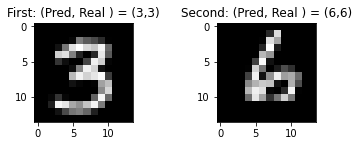

In [104]:
#### Run this to plot some examples
j = 1 # Change this from 0 to 999 to visualize a few examples


fig = plt.figure()
prediction, digit1, digit2 = model(train_images1, train_images2)
for k in range(prediction.size()[0]):
    prediction[k] = 0.0 if prediction[k]<0.5 else 1.0
first_digit = train_images1[j]
_, first_digit_predicted = digit1.max(-1)
second_digit = train_images2[j]
_, second_digit_predicted = digit2.max(-1)
target = train_target[j]
label_image1 = str(int(train_classes_images1[j].item()))
label_image2 = str(int(train_classes_images2[j].item()))

print('Target = ', target.item(), 'Predicted = ', prediction[j].item())
first_digit = np.array(first_digit, dtype='float')
second_digit = np.array(second_digit, dtype='float')
pixels = first_digit.reshape((14, 14))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(pixels, cmap='gray')
plt.title('First: (Pred, Real ) = ('+ str(first_digit_predicted[j].item()) + ','+ label_image1+')')
pixels2 = second_digit.reshape((14, 14))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(pixels2, cmap='gray')
plt.title('Second: (Pred, Real ) = ('+ str(second_digit_predicted[j].item()) + ','+ label_image2+')')
plt.show()
